In this code, we look into solving the Navier-Stokes equation for an incompressible fluid in a lid driven cavity. The Navier-Stokes and Incompressiblility condition is given by:


$$\frac{\partial{\vec{u}}}{\partial{t}} + (\vec{u} \cdot \vec{\nabla}{\vec{u}})\vec{u} = -\frac{1}{\rho}\vec{\nabla}{p} + \nu\vec{\nabla}^2\vec{u} + \vec{g}$$

$$\vec{\nabla} \cdot \vec{u} = 0$$
Where
$p$: pressure
$u$: Euclerian velocity
$\rho$: the fluids density (constant due to incompressible)
$\nu$: the kinematic viscosity given by: $\frac{\eta}{\rho}$, with $\eta$ being the viscosity
$g$: gravity experienced by the fluid

Similar to that of the example at https://www.youtube.com/watch?v=BQLvNLgMTQE, here we will explore the Navier-Stokes equation in 2D using Chorin's Projection method, with finite element method. Note I modified the domain inputs to be arbirary

The code is broken into these steps:
First, we solve the momentum equation without the pressure gradient, by introducing a tentative Velocity for both coordinates. Line 102-106. We do this with a forward difference method

Second, we solve the Pressure Poisson's equation using a central difference method to calculate the pressure seen in Lines 126-137 specifically we use the tentative velocity in the rhs in line 130, defined in line 124.

Third, we use the updating pressure to correct our velocity. Because the tentative velocity is considered compressible, the pressure will correct/project our solution onto the incompressibility constraint. When doing this, we have to reestablish our boundary conditions for the velocity in line 147.

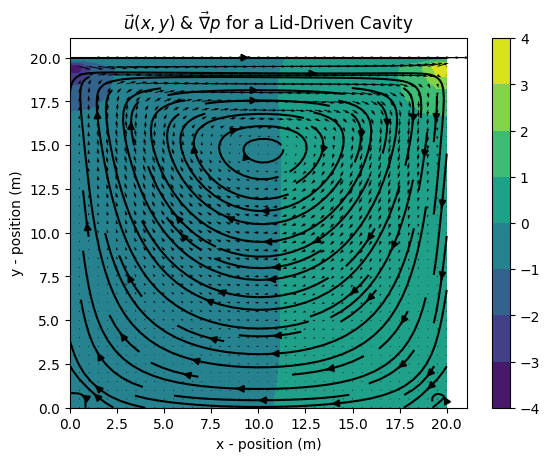

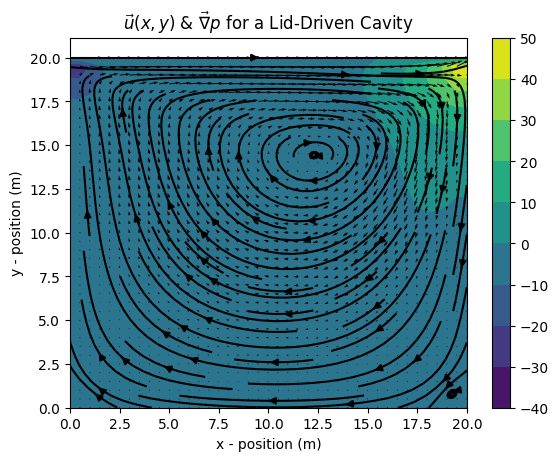

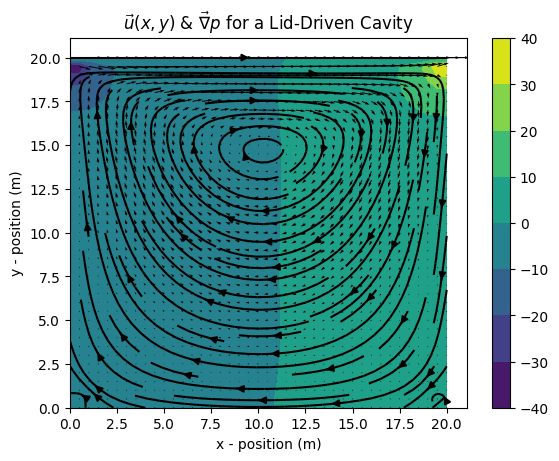

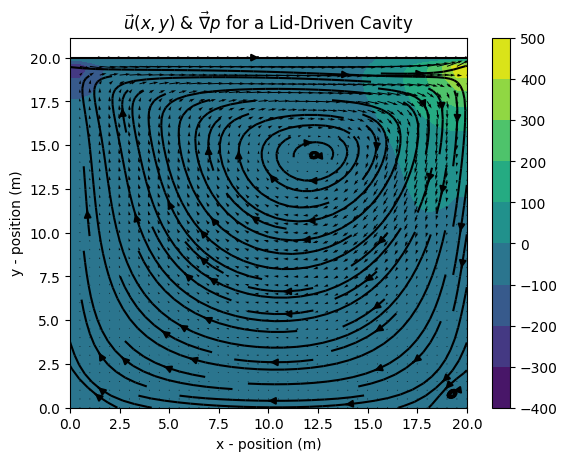

In [2]:
"""
Title: Navier_Stokes_Cavity
Author & Credit to: Felix Köhler @ https://www.linkedin.com/in/felix-koehler/
    Code: https://www.youtube.com/watch?v=BQLvNLgMTQE
    Github: https://github.com/Ceyron/machine-learning-and-simulation/tree/main
Modified by: Peter Kveton
Date: 12/2/23

"""

# Input Commands
N_POINTS = 41
#DOMAIN_SIZE = 1.0 #
#DOMAIN_SIZE_X = 20.0
#DOMAIN_SIZE_Y = 60.0  # eddies in the corners forming the fluid in the corners is trapped by the cavity bounds forming eddies
N_ITERATION = 500
TIME_STEP_LENGTH = 0.001
KINEMATC_VISCOSITY = 0.1        # nu

# rho = 1, 10
# horizontal velcoty = 1, 10
# 4 total graphs, 1;1, 1;10, 10;1, 10;10
#DENSITY = 1.0                   # rho and prop to pressure high rho high pressure, more mass more impact and more press
#HORIZONTAL_VELOCITY_TOP = 1.0  # velocity prop to the pressure and the sink centering

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5


import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


def Navier_Stokes_Cavity(DENSITY, HORIZONTAL_VELOCITY_TOP, DOMAIN_SIZE_X, DOMAIN_SIZE_Y):
    element_length = DOMAIN_SIZE / (N_POINTS - 1)                # step size of each term
    x_array = np.linspace(0.0, DOMAIN_SIZE_X, N_POINTS)         # range of points for x values
    y_array = np.linspace(0.0, DOMAIN_SIZE_Y, N_POINTS)         # range of points for y values
    x_mesh, y_mesh = np.meshgrid(x_array, y_array)

    # initial conditions: fluid is at rest, no pressure, and zero velocities
    u_previous = np.zeros_like(x_mesh)  # velocity in x direction
    v_previous = np.zeros_like(y_mesh)  # velocity in y direction
    pressure_previous = np.zeros_like(x_mesh) # pressure at each coordinate initialy 0



    # Solving Poisson's Equation
    def central_difference_in_x(field):
        diffx = np.zeros_like(field)  # matrix/array of zeros with same dimensions as input field
        # exclude inputting values in the outer data points enacting the BC
        diffx[1:-1, 1:-1] = (
            field[1:-1, 2: ] - field[1:-1, 0:-2]
        ) / (
            2 * element_length
        )
        # the field is given by [y1:y2, x1:x2] the y terms remain the same [1:-1],
        # while the x terms go from [1 + 1:-1 + 1], and [1 - 1: -1 -1] ie advanced by one and
        # subtracted by 1 thus central difference
        return diffx
    def central_difference_in_y(field):
        # like diff in x, we do the same operation but on the [y:y] terms
        diffy = np.zeros_like(field)

        diffy[1:-1, 1:-1] = (
            field[2: , 1:-1] - field[0:-2, 1:-1]
        ) / (
            2 * element_length
        )
        # advanced by 1 and subtracted by 1 in y terms
        return diffy

    def laplacian(field):
        # 2D laplacian:
        lap = np.zeros_like(field)
        lap[1:-1, 1:-1] = (
             field[1:-1, 0:-2] + field[0:-2, 1:-1] - 4*field[1:-1, 1:-1] + field[1:-1, 2: ] + field[2: , 1:-1]
        ) / element_length**2
        return lap


    # stability factor
    maximum_possible_step_length = (0.5 * element_length**2/KINEMATC_VISCOSITY)
    # from the heat equation
    if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * maximum_possible_step_length:
        raise RuntimeError('Stability not guaranteed')

    # accuracy of the field based on the number of iterations we do for the derivatives
    for _ in range(N_ITERATION):
        # get the partial derivatives for u_previous and v_previous in the x and y direction
        # recall u and v are mesh/grids ie matrices based on the x-y domain/ vector points
        d_u_prev__dx = central_difference_in_x(u_previous)
        d_u_prev__dy = central_difference_in_y(u_previous)
        d_v_prev__dx = central_difference_in_x(v_previous)
        d_v_prev__dy = central_difference_in_y(v_previous)

        # get the laplacian as well for both:
        lap__u_prev = laplacian(u_previous)
        lap__v_prev = laplacian(v_previous)


        # Calculate the Tentative Velocity by solving the momentum equation without the pressure gradient
        # Forward Difference Euler evolution
        u_tentative = (u_previous + TIME_STEP_LENGTH * (-(u_previous * d_u_prev__dx + v_previous * d_u_prev__dy)
                                                        + KINEMATC_VISCOSITY * lap__u_prev))
        v_tentative = (v_previous + TIME_STEP_LENGTH * (-(u_previous * d_v_prev__dx + v_previous * d_v_prev__dy)
                                                        + KINEMATC_VISCOSITY * lap__v_prev))
        # Apply the Dirichlet Boundary Conditions
        u_tentative[0, :] = 0.0  # bottom bound = 0: y = 0, all x
        u_tentative[:, 0] = 0.0  # left bound = 0: all y, x = 0
        u_tentative[:, -1] = 0.0 # right bound = 0: all y, x = last term
        u_tentative[-1, :] = HORIZONTAL_VELOCITY_TOP  # top bound unbounded: y = last term, all x

        v_tentative[0, :] = 0.0  # bottom bound = 0: y = 0, all x
        v_tentative[:, 0] = 0.0  # left bound = 0: all y, x = 0
        v_tentative[:, -1] = 0.0  # right bound = 0: all y, x = last term
        v_tentative[-1, :] = 0.0 # top bound =0: y = last term, all x

        # Pressure Correction: Divergence of u = 0
        d_u_tentative__dx = central_difference_in_x(u_tentative)
        d_v_tentative__dy = central_difference_in_y(v_tentative)

        # Compute Pressure Poisson Equation Neumann Method (approx to the liner system by smoothing)
        rhs = (DENSITY / TIME_STEP_LENGTH * (d_u_tentative__dx + d_v_tentative__dy))

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            pressure_next = np.zeros_like(pressure_previous)
            pressure_next[1:-1, 1:-1] = 1/4 * (+ pressure_previous[1:-1, 0:-2] + pressure_previous[0:-2, 1:-1]
                                               + pressure_previous[1:-1, 2: ] + pressure_previous[2: , 1:-1]
                                               - element_length**2*rhs[1:-1, 1:-1]) # interior pts (1/4 from 5pt stencil except center pt)
            # boundary conditions: Neumann BC derivative across the boundary is 0, which is the current value of the next pt
            pressure_next[:, -1] = pressure_next[:, -2]
            pressure_next[0, :] = pressure_next[1, :]
            pressure_next[:, 0] = pressure_next[:, 1]
            pressure_next[-1, :] = 0.0  # Dirichlet still

            pressure_previous = pressure_next  # update for loop

        # velocity correction we need the derivative of p
        d_p_next__dx = central_difference_in_x(pressure_next)
        d_p_next__dy = central_difference_in_y(pressure_next)

        # correction such that fluid stays incompressible
        u_next = (u_tentative - TIME_STEP_LENGTH / DENSITY * d_p_next__dx)
        v_next = (v_tentative - TIME_STEP_LENGTH / DENSITY * d_p_next__dy)

        # enforce boundary again
        u_next[0, :] = 0.0
        u_next[:, 0] = 0.0
        u_next[:, -1] = 0.0
        u_next[-1, :] = HORIZONTAL_VELOCITY_TOP

        v_next[0, :] = 0.0
        v_next[:, 0] = 0.0
        v_next[:, -1] = 0.0
        v_next[-1, :] = 0.0

        # time update
        u_previous = u_next
        v_previous = v_next
        pressure_previous = pressure_next

    plt.figure()
    plt.contourf(x_mesh, y_mesh, pressure_next) # for pressure
    plt.colorbar()

    plt.quiver(x_mesh, y_mesh, u_next, v_next, color='black')
    #plt.title(r'$\vec{u}(x, y)$ & $\vec{\nabla}p$ for a Lid-Driven Cavity')
    #plt.xlabel('x - position (m)')
    #plt.ylabel('y - position (m)')
    plt.streamplot(x_mesh, y_mesh, u_next, v_next, color='black')
    plt.title(r'$\vec{u}(x, y)$ & $\vec{\nabla}p$ for a Lid-Driven Cavity')
    plt.xlabel('x - position (m)')
    plt.ylabel('y - position (m)')
    plt.savefig('20x20_r1_u1')
    plt.show()

    return

if __name__ == "__main__":
    # inputs: density, horizontal velocity, x domain, y domain
    Navier_Stokes_Cavity(1, 1, 20, 20)
    Navier_Stokes_Cavity(1, 10, 20, 20)
    Navier_Stokes_Cavity(10, 1, 20, 20)
    Navier_Stokes_Cavity(10, 10, 20, 20)

